#### Example API and Analysis Notebook

In [1]:
from git import Repo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

Repo.clone_from("https://github.com/costquestassociates/cqazapi-pytools.git", "cqazapipytools")
!pip install -r cqazapipytools/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [requests]1/6 [idna]


In [9]:
API_KEY = ""

if not API_KEY:
    try:
        with open('secrets.json', 'r') as f:
            secrets = json.load(f)
        API_KEY = secrets.get('apikey')
    except FileNotFoundError:
        API_KEY = None

if not API_KEY:
    raise RuntimeError("API key not found. Please fill in your API_KEY in the variable above.")

print(f"API_KEY: {API_KEY[:6] + '...' + API_KEY[-6:]}")

API_KEY: cq-ef3...93f481


### Use API to query Clarke County, Georgia

In [10]:
from cqazapipytools import *

VINTAGE = '202412'
FIELDS = ['location_id','blockfips','bdc_fiber','fibergreenfieldpassinv']
COUNTY_FIPS = '13059' # Clarke County, Georgia
LIMIT = None  # Set to an integer to limit number of records for testing

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    # Collect Fabric UUIDs inside the county
    county_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/counties?id={COUNTY_FIPS}', 'GET')
    collect = cp.collect(VINTAGE, county_geojson)

    if LIMIT:
        collect = collect[:LIMIT]

    # attach data
    results = cp.attach('202412',collect,FIELDS)

    # Write to CSV 
    cp.csvWrite(f'county_{COUNTY_FIPS}_fabric.csv', results)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

API request (1/0) to GET https://api.costquest.com/accountcontrol/listapis succeeded in 0.295s
API request (2/0) to GET https://api.costquest.com/geosvc/libgetgeo/tiger/2020/counties?id=13059 succeeded in 0.965s
API request (3/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.217s
API request (4/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.101s
API request (5/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.067s
API request (6/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.075s
API request (7/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.083s
API request (8/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.07s
API request (9/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.052s
API request (10/0) to POST https://api.costquest.com/fabric/202412/collect2 succeeded in 0.087s
API request (11/0) to POST h

In [11]:
results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)
service_map = {3: "Unserved", 2: "Underserved", 1: "Served"}
results_df["service_level"] = results_df["bdc_fiber"].map(service_map).astype("category")
results_df.head()

,bdc_fiber,blockfips,location_id,fibergreenfieldpassinv,service_level
0,3.0,130590301021012,1382719893,287.685173,Unserved
1,3.0,130590006002026,1084323879,277.894171,Unserved
2,3.0,130590301013000,1084324822,382.465907,Unserved
3,3.0,130591508003005,1084334941,739.296584,Unserved
4,3.0,130591306022006,1084350818,703.136414,Unserved


### Quick Plotting

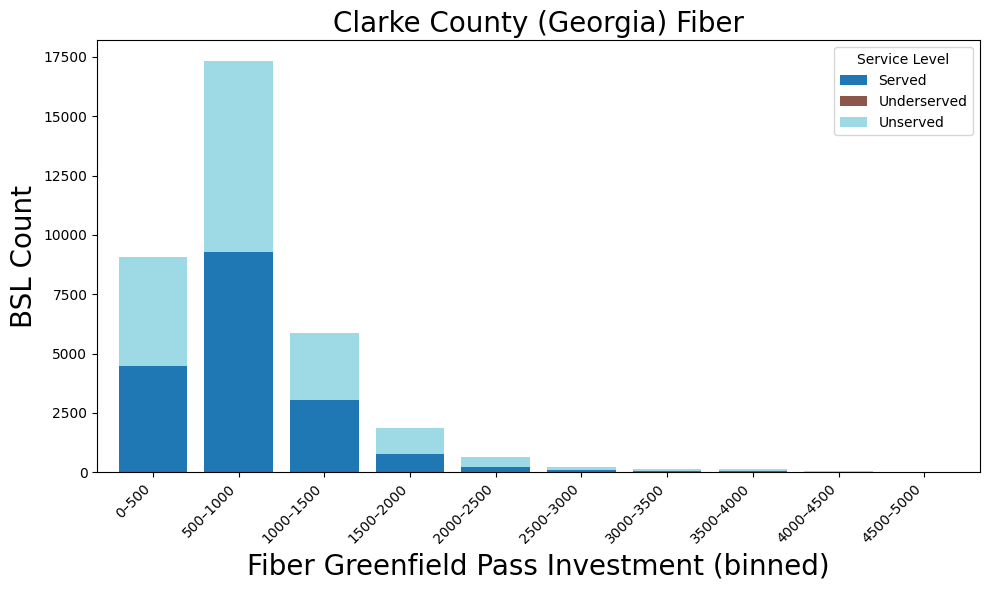

In [12]:
df = results_df.copy()

min_val = df['fibergreenfieldpassinv'].min()
max_val = 5000
bins = np.arange(0, max_val + 1, 500)

# Create a bin label column (intervals)
df['inv_bin'] = pd.cut(df['fibergreenfieldpassinv'], bins=bins, include_lowest=True)

# Group and count by bin and service level
grouped = df.groupby(['inv_bin', 'service_level'], observed=True).size().unstack(fill_value=0)

# #Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, width=0.8, colormap='tab20')

ax.set_xlabel('Fiber Greenfield Pass Investment (binned)', fontsize = 20)
ax.set_ylabel('BSL Count', fontsize = 20)
ax.set_title('Clarke County (Georgia) Fiber', fontsize = 20)
ax.legend(title='Service Level')

# Improve xlabels: show bin ranges nicely
ax.set_xticklabels([f'{np.abs(interval.left):.0f}–{interval.right:.0f}' for interval in grouped.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()